**Import necessary packages**

In [385]:
#Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error

**Import cleaned datasets**

In [386]:
#Import user_ratings
user_ratings = pd.read_csv('./clean_data/user_ratings_clean.csv')

In [387]:
#Import cleaned movie_data 
movie_data = pd.read_csv('./clean_data/movie_data_clean.csv')

**General Review of Each Imported Dataset**

In [388]:
#Check 1st few observations of user ratings
user_ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story
1,5,1,4.0,Toy Story
2,7,1,4.5,Toy Story
3,15,1,2.5,Toy Story
4,17,1,4.5,Toy Story


In [390]:
#Check 1st few observations for movie_data
movie_data.head()

,title,overview,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",1,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Jumanji,When siblings Judy and Peter discover an encha...,2,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,3,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",4,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,Father of the Bride Part II,Just when George Banks has recovered from his ...,5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [391]:
#Check for null observations - user_ratings
user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73503 entries, 0 to 73502
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   73503 non-null  int64  
 1   movieId  73503 non-null  int64  
 2   rating   73503 non-null  float64
 3   title    73503 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 2.2+ MB


In [392]:
#Check for null observations - movie_data
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6917 entries, 0 to 6916
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               6917 non-null   object
 1   overview            6917 non-null   object
 2   movieId             6917 non-null   int64 
 3   (no genres listed)  6917 non-null   int64 
 4   Action              6917 non-null   int64 
 5   Adventure           6917 non-null   int64 
 6   Animation           6917 non-null   int64 
 7   Children            6917 non-null   int64 
 8   Comedy              6917 non-null   int64 
 9   Crime               6917 non-null   int64 
 10  Documentary         6917 non-null   int64 
 11  Drama               6917 non-null   int64 
 12  Fantasy             6917 non-null   int64 
 13  Film-Noir           6917 non-null   int64 
 14  Horror              6917 non-null   int64 
 15  IMAX                6917 non-null   int64 
 16  Musical             6917

## Non-personalized recommendations

**Movies with Greatest Number of Reviews**

This initial non-personalized recommendation will review the movies with the greatest number of reviews in the user ratings data. No consideration is being given to the numeric ratings of these movies, only the frequency with which they've been reviewed.

In [393]:
#Create a function to review top-10 movies with most reviews
def movies_most_reviews(user_ratings):
    
    #Count the reviews per movie title, sorts automatically in descending order
    movie_popularity = user_ratings['title'].value_counts()
    
    #Return observations with top-10 # of reviews from this df
    return movie_popularity.head(10).index

In [394]:
#Run function to return top-10 movies with most user ratings
movies_most_reviews(user_ratings)

Index(['Forrest Gump', 'Pulp Fiction', 'Jurassic Park', 'Braveheart',
       'Terminator 2: Judgment Day', 'Schindler's List', 'Fight Club',
       'Toy Story', 'American Beauty', 'Seven'],
      dtype='object', name='title')

**Movies with Highest Average Rating**

The last impersonalized recommendation method had clear faults, it didn't even consider the numeric user ratings. It operated under the assumption that if a movie occurred more frequently in the user ratings dataset (i.e. it had been watched by more people) it was better and this isn't necessarily true. 

Here we will look at the highest average mean ratings for titles in the user ratings dataset.

In [395]:
#Create a function to review top-10 movies with highest average ratings
def movies_highest_avg_rating(user_ratings):
    
    #Group user ratings titles/ratings by title & take average rating per film
    average_rating_df = user_ratings[["title", "rating"]].groupby('title').mean()
    
    #Sort average ratings in descending order
    sorted_average_rating_df = average_rating_df.sort_values(by = "rating", ascending = False)
    
    #Return top-10 movies with highest average rating
    return sorted_average_rating_df.head(10).index

In [396]:
#Run function to return top-10 movies with highest average ratings
movies_highest_avg_rating(user_ratings)

Index(['Going Places', 'Moonlight', 'Shogun Assassin', 'Happy Feet Two',
       'My Love', 'My Life as McDull', 'My Left Eye Sees Ghosts',
       'Tickling Giants', 'Harlan County U.S.A.', 'Siam Sunset'],
      dtype='object', name='title')

**Movies with Greater than 50 Reviews with Highest Average Rating**

Reviewing movies by highest average rating is an improvement, but by only reviewing by highest average rating- this doesn't account for movie titles where only 1 user may have watched it and really enjoyed the movie. Therefore, the high rating may driven by there only being one enthusiastic viewer of that movie. 

To improve upon this, we will look at the highest average ratings in the dataset of movies that have been reviewed by at least 50 viewers. This helps to ensure that movies with the highest average ratings likely have broader appeal and truly are well-liked by the public.

In [ ]:
#Create a function to review top-10 movies with highest average rating that have 50+ reviews
def movies_highest_avg_rating_50_plus_reviews(user_ratings):
    
    #Count the reviews per movie title, sorts automatically in descending order
    movie_popularity = user_ratings["title"].value_counts()
    
    #Filter for movies with greater than 50 reviews
    popular_movies = movie_popularity[movie_popularity > 50].index
    
    #Filter user ratings df for only movies that have more than 50 reviews
    popular_movies_rankings = user_ratings[user_ratings["title"].isin(popular_movies)]
    
    #Sort the movies that have at least 50 reviews by rating in descending order
    sorted_popular_movies_rankings = popular_movies_rankings.sort_values(by = 'rating', ascending = False)
    
    return popular_movies_rankings.head(10)

In [314]:
# Create a list of only movies appearing > 50 times in the dataset 
movie_popularity = user_ratings["title"].value_counts()
popular_movies = movie_popularity[movie_popularity > 50].index
print(popular_movies)

Index(['Forrest Gump', 'Shawshank Redemption, The', 'Pulp Fiction',
       'Silence of the Lambs, The', 'Matrix, The',
       'Star Wars: Episode IV - A New Hope', 'Jurassic Park', 'Braveheart',
       'Terminator 2: Judgment Day', 'Schindler's List',
       ...
       'Million Dollar Baby', 'Mystic River', 'Blow', 'Mulholland Drive',
       'Bad Boys', 'The Devil's Advocate', 'Training Day', 'Splash',
       'Chocolat', 'Army of Darkness'],
      dtype='object', name='title', length=447)


In [315]:
# Use this popular_movies list to filter the original DataFrame
popular_movies_rankings = user_ratings[user_ratings["title"].isin(popular_movies)]
popular_movies_rankings

,userId,movieId,rating,title
0,1,1,4.0,Toy Story
1,5,1,4.0,Toy Story
2,7,1,4.5,Toy Story
3,15,1,2.5,Toy Story
4,17,1,4.5,Toy Story
...,...,...,...,...
98559,605,26152,3.0,Batman
98560,606,26152,3.5,Batman
99783,550,167296,0.5,Iron Man
100585,606,5990,3.5,Pinocchio


In [316]:
# Find the average rating given to these frequently watched films
popular_movies_average_rankings = popular_movies_rankings[["title", "rating"]].groupby('title').mean()
print(popular_movies_average_rankings.sort_values(by="rating", ascending=False).head())

                                                      rating
title                                                       
Shawshank Redemption, The                           4.429022
Godfather, The                                      4.289062
Fight Club                                          4.272936
Cool Hand Luke                                      4.271930
Dr. Strangelove or: How I Learned to Stop Worry...  4.268041


**Movies Commonly Viewed By the Same Person Together**

So far we have been looking at movies in isolation, it may be helpful to expand upon this and review movies that are commonly viewed by the same user together. This helps to cater recommendations more specifically to users based on the preferences of other users who are assumed to be similar based on their movie-watching history.

In [317]:
#Create a function to find permutations in dataset
def create_pairs(x):
    pairs = pd.DataFrame(list(permutations(x.values, 2)), columns = ['movie_a', 'movie_b'])
    return pairs

In [318]:
#Apply create_pairs function to user_ratings
movie_pairs = user_ratings.groupby('userId')['title'].apply(create_pairs)

In [319]:
#Review movie_pairs
movie_pairs

movie_a                    movie_b
userId                                              
1      0        Toy Story           Grumpier Old Men
       1        Toy Story                       Heat
       2        Toy Story                      Seven
       3        Toy Story        Usual Suspects, The
       4        Toy Story        From Dusk Till Dawn
...                   ...                        ...
610    1693897         31                 Gen-X Cops
       1693898         31                  Bloodmoon
       1693899         31  Sympathy for the Underdog
       1693900         31                     Hazard
       1693901         31                Blair Witch

[60793300 rows x 2 columns]

In [320]:
#Drop the userId index
movie_pairs = movie_pairs.reset_index(drop = True)

In [321]:
#Review movie_pairs with reset index
movie_pairs

,movie_a,movie_b
0,Toy Story,Grumpier Old Men
1,Toy Story,Heat
2,Toy Story,Seven
3,Toy Story,"Usual Suspects, The"
4,Toy Story,From Dusk Till Dawn
...,...,...
60793295,31,Gen-X Cops
60793296,31,Bloodmoon
60793297,31,Sympathy for the Underdog
60793298,31,Hazard


In [322]:
#Review how frequently each pair occurs
movie_pair_counts = movie_pairs.groupby(['movie_a', 'movie_b']).size()
movie_pair_counts

movie_a            movie_b                            
'71                10 Cloverfield Lane                    1
                   127 Hours                              1
                   13 Assassins                           1
                   13 Hours                               1
                   13 Sins                                1
                                                         ..
À nous la liberté  Willow                                 1
                   Willy Wonka & the Chocolate Factory    1
                   Wizard of Oz, The                      1
                   World According to Garp, The           1
                   X-Files: Fight the Future, The         1
Length: 25334082, dtype: int64

In [323]:
#Convert movie_pairs_counts to dataframe 
movie_pair_counts_df = movie_pair_counts.to_frame(name = 'size').reset_index()

In [324]:
#Review 1st few observations
movie_pair_counts_df.head()

,movie_a,movie_b,size
0,'71,10 Cloverfield Lane,1
1,'71,127 Hours,1
2,'71,13 Assassins,1
3,'71,13 Hours,1
4,'71,13 Sins,1


In [325]:
#Sort movie_pair_counts_df
sorted_counts_df = movie_pair_counts_df.sort_values(by = 'size', ascending = False)

In [326]:
#Review sorted_counts_df
sorted_counts_df

,movie_a,movie_b,size
8240526,Forrest Gump,"Shawshank Redemption, The",231
19868737,"Shawshank Redemption, The",Forrest Gump,231
8239837,Forrest Gump,Pulp Fiction,230
17841190,Pulp Fiction,Forrest Gump,230
19871837,"Shawshank Redemption, The",Pulp Fiction,222
...,...,...,...
10451210,Home Alone 2: Lost in New York,Turbo Kid,1
10451209,Home Alone 2: Lost in New York,Turbo,1
10451208,Home Alone 2: Lost in New York,Tupac: Resurrection,1
10451207,Home Alone 2: Lost in New York,Tully,1


In [327]:
#Can find the most frequently pair movies by filtering by for a specific title
#For example filtering where movie_a == The Shawshank Redemption
shawshank_counts = sorted_counts_df[sorted_counts_df['movie_a'] == 'Shawshank Redemption, The']

In [328]:
#Top ten movies seen with Shawshank Redemption
shawshank_counts_top10 = shawshank_counts.head(10)

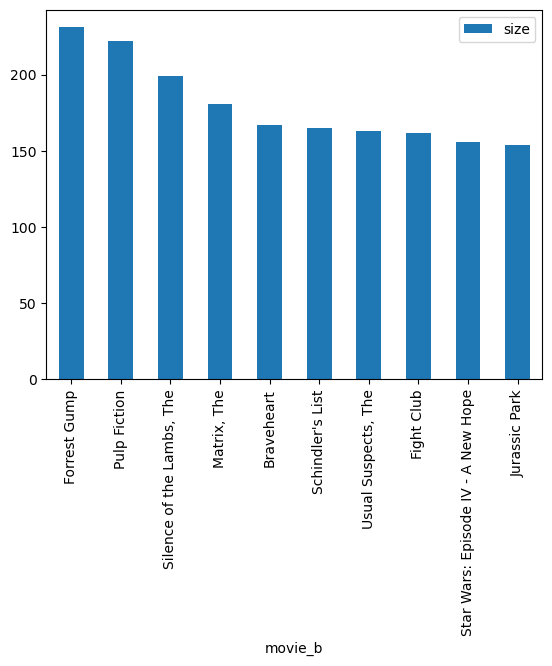

In [329]:
#Create a plot of most commonly viewed movies with The Shawshank Redemption
shawshank_counts_top10.plot.bar(x = 'movie_b')
plt.show()

**Movies df cleaning**

In [330]:
#Review movies df
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [331]:
#Extract the year at the end of each value in 'title' column & add as a new column 'year'
movies['year'] = movies.title.str.extract("(?<=\()(.*?)(?=\)$)")

#Remove the (year) at the end of each 'title'
movies['title'] = movies.title.str.replace(r"\(.*\)","", regex= True)

#Remove leading and trailing white space from 'title' column
movies['title'] = movies['title'].apply(lambda x: x.strip())

In [332]:
#Review changes in movies df
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [333]:
movies.dtypes

movieId     int64
title      object
genres     object
year       object
dtype: object

In [334]:
#Split the genres by separator = "|"
movies['genres'] = movies['genres'].str.split("|", expand = False)

In [335]:
#Review movies_genres
movies.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [336]:
#Create MultiLabelBinarizer object
mlb = MultiLabelBinarizer()
array = mlb.fit_transform(movies.genres.to_numpy())

#Create a dataframe with column names being the classes
genres_df = pd.DataFrame(array, index = movies.index, columns = mlb.classes_)

In [337]:
#Review genres_df
genres_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [338]:
#Combine the movies df with new genres_df
#Drop the 'genres' column from the original movies df
movies_genres = pd.concat([movies, genres_df], axis = 1).drop(columns = 'genres')

In [339]:
#Review first few observations of the new movies_genres df
movies_genres.head()

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [340]:
#Review the shape of the movies_genres df
movies_genres.shape

(9742, 23)

In [341]:
#Review datatypes of each column
movies_genres.dtypes

movieId                int64
title                 object
year                  object
(no genres listed)     int32
Action                 int32
Adventure              int32
Animation              int32
Children               int32
Comedy                 int32
Crime                  int32
Documentary            int32
Drama                  int32
Fantasy                int32
Film-Noir              int32
Horror                 int32
IMAX                   int32
Musical                int32
Mystery                int32
Romance                int32
Sci-Fi                 int32
Thriller               int32
War                    int32
Western                int32
dtype: object

In [342]:
movies[['title', 'year']].value_counts().reset_index(name = 'count')

,title,year,count
0,Emma,1996,2
1,War of the Worlds,2005,2
2,Eros,2004,2
3,Saturn 3,1980,2
4,Confessions of a Dangerous Mind,2002,2
...,...,...,...
9709,Friends & Lovers,1999,1
9710,Friends with Benefits,2011,1
9711,Friends with Kids,2011,1
9712,Friends with Money,2006,1


Jaccard similiarity - the number of attributes that two items have in common/total number of their combined attributes

Jaccard similiarity will always be between 0 and 1. The more attributes that two items have in common, the higher the score.

In [343]:
#Create a list for all movie titles- movies
movies = movies_genres['title'].values

In [344]:
#Inspect movies
print(movies)

['Toy Story' 'Jumanji' 'Grumpier Old Men' ... 'Flint'
 'Bungo Stray Dogs: Dead Apple' 'Andrew Dice Clay: Dice Rules']


In [345]:
#Create a dataframe containing movie names as indices & genres as columns
movie_index_genres = pd.DataFrame(movies_genres.iloc[:, 3:23])
movie_index_genres.set_index(movies, inplace = True, drop = True)

In [346]:
#Inspect new dataframe
movie_index_genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
Toy Story,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Jumanji,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Grumpier Old Men,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Waiting to Exhale,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
Father of the Bride Part II,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
No Game No Life: Zero,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
Flint,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Bungo Stray Dogs: Dead Apple,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Item to Item Recommendations

**Jaccard Similarity Score Using Movie Genre Data**

In generating user recommendations for movies to view, it could be helpful to quantify how similar 2 movies are to one another. A method to do this is using the Jaccard Similarity Score.

The Jaccard similarity score is a statistic to measure the similarity between two data sets. It is measured as the size of the intersection of two sets divided by the size of their union. As shown below. It is a useful similarity metric to use when comparing similarity between 2 sets - like genre classifications for 2 different movies.

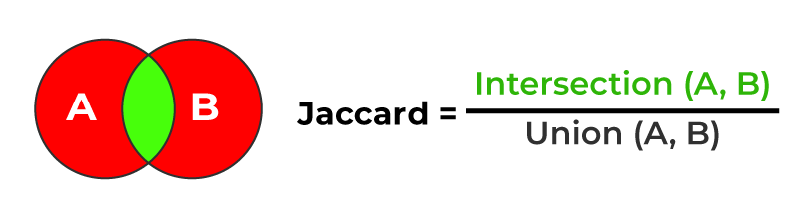

In [347]:
#Calculating the Jaccard similarity score for 2 movies- 'Toy Story' & 'Jumanji'

#Select category attributes for each movie
toy_story_row = movie_index_genres.loc['Toy Story', :]
jumanji_row = movie_index_genres.loc['Jumanji', :]

In [348]:
#Calculate Jaccard similarity score between Toy Story & Jumanji
jaccard_score(toy_story_row, jumanji_row, average = 'binary')

0.6

In [349]:
#Finding the distance between all movies in the dataframe
jaccard_distances = pdist(movie_index_genres.values, metric = 'jaccard')

In [350]:
#Inspect jaccard_distances & its shape
print(jaccard_distances)
print(jaccard_distances.shape)

[0.4        0.83333333 0.85714286 ... 1.         1.         1.        ]
(47448411,)


In [351]:
#Square the jaccard distances
square_jaccard_distances = squareform(jaccard_distances)

In [352]:
#Inspect square_jaccard_distances & its shape
#Dimensions should be # of movies in original df x # of movies in original df
print(square_jaccard_distances)
print(square_jaccard_distances.shape)

[[0.         0.4        0.83333333 ... 1.         0.83333333 0.8       ]
 [0.4        0.         1.         ... 1.         1.         1.        ]
 [0.83333333 1.         0.         ... 1.         1.         0.5       ]
 ...
 [1.         1.         1.         ... 0.         1.         1.        ]
 [0.83333333 1.         1.         ... 1.         0.         1.        ]
 [0.8        1.         0.5        ... 1.         1.         0.        ]]
(9742, 9742)


In [353]:
#Square_jaccard_distances gives us the differences between each attribute
#To get the similarity per attribute you can take this & subtract from 1
jaccard_similarity_array = 1 - square_jaccard_distances

In [354]:
#Inspect jaccard_similarity_array & its shape
print(jaccard_similarity_array)
print(jaccard_similarity_array.shape)

[[1.         0.6        0.16666667 ... 0.         0.16666667 0.2       ]
 [0.6        1.         0.         ... 0.         0.         0.        ]
 [0.16666667 0.         1.         ... 0.         0.         0.5       ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.16666667 0.         0.         ... 0.         1.         0.        ]
 [0.2        0.         0.5        ... 0.         0.         1.        ]]
(9742, 9742)


In [355]:
#Put the jaccard_similarity_array into a dataframe
distance_df = pd.DataFrame(jaccard_similarity_array, index = movies, columns = movies)

In [356]:
#Check the 1st few observations
distance_df.head()

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Gintama: The Movie,anohana: The Flower We Saw That Day - The Movie,Silver Spoon,Love Live! The School Idol Movie,Jon Stewart Has Left the Building,Black Butler: Book of the Atlantic,No Game No Life: Zero,Flint,Bungo Stray Dogs: Dead Apple,Andrew Dice Clay: Dice Rules
Toy Story,1.000000,0.6,0.166667,0.142857,0.200000,0.0,0.166667,0.400000,0.0,0.142857,...,0.285714,0.166667,0.166667,0.2,0.0,0.500000,0.600000,0.000000,0.166667,0.200000
Jumanji,0.600000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.666667,0.0,0.200000,...,0.000000,0.000000,0.000000,0.0,0.0,0.166667,0.200000,0.000000,0.000000,0.000000
Grumpier Old Men,0.166667,0.0,1.000000,0.666667,0.500000,0.0,1.000000,0.000000,0.0,0.000000,...,0.200000,0.000000,0.333333,0.0,0.0,0.200000,0.250000,0.000000,0.000000,0.500000
Waiting to Exhale,0.142857,0.0,0.666667,1.000000,0.333333,0.0,0.666667,0.000000,0.0,0.000000,...,0.166667,0.250000,0.666667,0.0,0.0,0.166667,0.200000,0.333333,0.000000,0.333333
Father of the Bride Part II,0.200000,0.0,0.500000,0.333333,1.000000,0.0,0.500000,0.000000,0.0,0.000000,...,0.250000,0.000000,0.500000,0.0,0.0,0.250000,0.333333,0.000000,0.000000,1.000000


In [357]:
#With the jaccard_similarity_score df, we can easily compare to movies

#Comparing two similar movies- like 'GoldenEye' & 'Skyfall' (both James Bond, action movies), should yield a similarity score near 1
print(distance_df['GoldenEye']['Skyfall'])

#Comparing 2 dissimilar movies- like 'Toy Story' & 'GoldenEye' (1 is children's movie, 1 is James Bond action movie), should yield a low similarity score close to 0
print(distance_df['Toy Story']['GoldenEye'])

0.75
0.1428571428571429


In [358]:
#You can review the Jaccard similarity scores of 1 movie- such as Thor- to all other movies in the dataset like below
#Again, scores closer to 1 indicate higher similarity & scores closer to 0 indicate dissimilarity
Thor_similarities = distance_df.loc['Thor'].sort_values(ascending = False)

In [359]:
#Review similarity of Thor to other movies in dataset
#Top 10 movies in the dataset that Thor is similar to
Thor_similarities.head(10)

Thor                                            1.000000
Harry Potter and the Deathly Hallows: Part 2    0.833333
Beowulf & Grendel                               0.800000
The Huntsman Winter's War                       0.800000
In the Name of the King III                     0.800000
Thor: The Dark World                            0.800000
Oz the Great and Powerful                       0.800000
Harry Potter and the Deathly Hallows: Part 1    0.800000
Harry Potter and the Order of the Phoenix       0.800000
Clash of the Titans                             0.800000
Name: Thor, dtype: float64

In [360]:
#Top 10 movies in dataset that Thor is least similar to
Thor_similarities.tail(10)

Style Wars                               0.0
In July                                  0.0
Perfect Murder, A                        0.0
Ugly, The                                0.0
Paradise Lost 2: Revelations             0.0
Daria: Is It Fall Yet?                   0.0
Late Night Shopping                      0.0
Darkness                                 0.0
American Psycho II: All American Girl    0.0
Andrew Dice Clay: Dice Rules             0.0
Name: Thor, dtype: float64

**TF-IDF & Cosine Similarity using Movie Overview Text**

Another comparison that we can use for 2 films is using the movie overview data. To start this comparison, we will employ TF-IDF). This technique that can be useful in text applications. It is equal to the expression below and is useful because as the formula demonstrates it reduces the weight of common words that occur in many documents and increases the weight of words that do not occur in many documents. 

We can use this technique to measure how important a term is within a movie text overview vs the entire set of movie text overviews. 

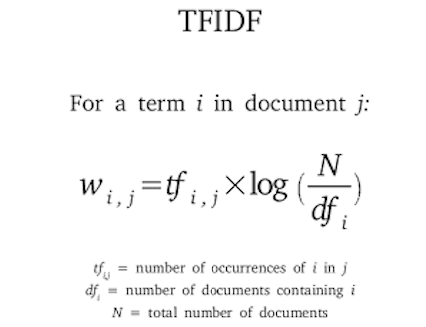

In [361]:
#min_df argument specifies minimum occurence words must appear to be counted
#max_df argument specifies maximum % occurence that words can have to be counted
#i.e. if word appears too frequently it will not be helpful in analysis 
tfidfvec = TfidfVectorizer(min_df = 2, max_df = 0.7)

In [362]:
vectorized_data = tfidfvec.fit_transform(movies_overview['overview'])
print(tfidfvec.get_feature_names)

<bound method CountVectorizer.get_feature_names of TfidfVectorizer(max_df=0.7, min_df=2)>


In [363]:
#Row for each movie & column for each feature or word
print(vectorized_data.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [364]:
#Put vectorized data into a dataframe
tfidf_df = pd.DataFrame(vectorized_data.toarray(), index = movies_overview['title'].values, columns = tfidfvec.get_feature_names_out())

In [365]:
tfidf_df

,00,000,007,10,100,1000,101,108,10th,11,...,zones,zoo,zooey,zookeeper,zoologist,zoologists,zoom,zurich,émigré,ôtomo
Toy Story,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Waiting to Exhale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LEGO DC Super Hero Girls: Brain Drain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cinderella,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Savages,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pickpocket,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cosine similarity measures the similarity between two vectors of an inner product space. It is measured by the cosine of the angle between two vectors and determines whether two vectors are pointing in roughly the same direction. It is often used to measure document similarity in text analysis as it is a helpful similarity metric to use when items have more variation in their data, which is what we are doing in this case with our TF-IDF data.

A larger values indicates high similarity whereas a lower value indicates low similarity.

In [366]:
#Find the cosine similarity between all items
cosine_similarity_array = cosine_similarity(tfidf_df)

In [367]:
#Create cosine_similarity_df where movie names are indices & rows to assess similarity between movies
cosine_similarity_df = pd.DataFrame(cosine_similarity_array, index = tfidf_df.index, columns = tfidf_df.index)

In [368]:
#Review cosine_similarity_df
cosine_similarity_df.head()

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Self-criticism of a Bourgeois Dog,Sahara,Der Herr Karl,Coming Home,Love,LEGO DC Super Hero Girls: Brain Drain,Cinderella,Savages,Pickpocket,Robin Hood
Toy Story,1.000000,0.027468,0.007247,0.007690,0.025091,0.008822,0.008724,0.002400,0.014232,0.004802,...,0.005709,0.028062,0.0,0.000000,0.012287,0.024922,0.013938,0.016881,0.028372,0.009380
Jumanji,0.027468,1.000000,0.050302,0.027236,0.029207,0.063241,0.015209,0.006506,0.106360,0.005645,...,0.006711,0.020463,0.0,0.071646,0.000000,0.035274,0.033696,0.029027,0.067236,0.007961
Grumpier Old Men,0.007247,0.050302,1.000000,0.036353,0.049681,0.002728,0.005047,0.020558,0.008693,0.000000,...,0.000000,0.012465,0.0,0.036713,0.011962,0.007867,0.034764,0.005273,0.048854,0.013731
Waiting to Exhale,0.007690,0.027236,0.036353,1.000000,0.013502,0.025697,0.013413,0.009948,0.000000,0.011248,...,0.000000,0.000000,0.0,0.016939,0.000000,0.014313,0.007123,0.023032,0.042305,0.013711
Father of the Bride Part II,0.025091,0.029207,0.049681,0.013502,1.000000,0.008073,0.046729,0.011481,0.040540,0.012315,...,0.042655,0.079041,0.0,0.014800,0.011572,0.039749,0.092730,0.018329,0.150840,0.017733


In [369]:
#Find the cosine similarity based on plot overview text data between a specific movie & all other movies in the dataset as shown below

#Isolate the observation for the specific movie you are looking for in cosine_similarity_df (i.e. 'Grumpier Old Mean')
grumpier_old_men_cosine_sims = cosine_similarity_df.loc['Grumpier Old Men']

#Sort the values of this row in descending order to see highest similar movies to lowest similar movies by plot overview for isolate movie
grumpier_old_men_cosine_sims.sort_values(ascending = False)

Grumpier Old Men        1.000000
Max                     0.194551
Go Fish                 0.183802
Fearless                0.178136
Heartbreakers           0.165384
                          ...   
Feast                   0.000000
Better Luck Tomorrow    0.000000
Stray Dog               0.000000
American Grindhouse     0.000000
Pacific Heights         0.000000
Name: Grumpier Old Men, Length: 8101, dtype: float64

In [370]:
#Review 10 most similar movies by plot overview text for 'Grumpier Old Men'
grumpier_old_men_cosine_sims.sort_values(ascending = False).head(10)

Grumpier Old Men           1.000000
Max                        0.194551
Go Fish                    0.183802
Fearless                   0.178136
Heartbreakers              0.165384
Rushmore                   0.163765
Bent                       0.153457
Collateral                 0.150702
The Secret Life of Pets    0.147341
Maelström                  0.140055
Name: Grumpier Old Men, dtype: float64

In [371]:
#Review 10 least similar movies by plot overview text for 'Grumpier Old Men'
grumpier_old_men_cosine_sims.sort_values(ascending = False).tail(10)

The Thief                             0.0
A Man from Boulevard des Capucines    0.0
Virus                                 0.0
Cinderella                            0.0
Little Children                       0.0
Feast                                 0.0
Better Luck Tomorrow                  0.0
Stray Dog                             0.0
American Grindhouse                   0.0
Pacific Heights                       0.0
Name: Grumpier Old Men, dtype: float64

In [372]:
#Review the cosine similarity based on plot overviews of 2 specific movies i.e. 'GoldenEye' & 'Skyfall'
cosine_similarity_df.loc['GoldenEye','Skyfall']

0.071998203051729

## User Profile Recommendations

**Use TF-IDF data to Generate User Profile Recommendations**

Our previous work has been related to item-item recommendations. 

We can expand upon this by using the tfidf_df previously created based on movie plot overviews to review the preferences of a specific user in our dataset.

In [373]:
#Extract ratings of a specific user - in this case userId = 5
user_5 = user_ratings[user_ratings['userId'] == 5]['title'].values

In [374]:
#Review movieId's reviewed by userId == 5
user_5

array(['Toy Story', 'Usual Suspects, The', 'Braveheart', 'Pulp Fiction',
       'Stargate', 'Clear and Present Danger', 'Mask, The',
       'Fugitive, The', "Schindler's List", 'Dances with Wolves',
       'Batman', 'Pinocchio', 'Fargo', 'Shawshank Redemption, The',
       'Get Shorty', 'Postman, The', 'Eat Drink Man Woman',
       'Heavenly Creatures', 'Like Water for Chocolate',
       'Four Weddings and a Funeral', 'In the Name of the Father',
       'Aladdin', 'Beauty and the Beast', 'Babe', 'Dead Man Walking',
       'Clueless', 'Apollo 13', 'Batman Forever',
       'Interview with the Vampire: The Vampire Chronicles',
       'Little Women', 'Legends of the Fall', 'Once Were Warriors',
       'Quiz Show', 'Ace Ventura: Pet Detective', 'Lion King, The',
       'True Lies', 'Addams Family Values', 'In the Line of Fire',
       'Remains of the Day, The', 'Secret Garden, The', 'Shadowlands',
       'Terminator 2: Judgment Day', 'Snow White and the Seven Dwarfs',
       'Pretty Woman']

In [375]:
#Review number of movies reviewed by userId == 5
len(user_5)

44

In [376]:
#Filter movies reviewed by userId = 5 from tfidf_df 
user_movies = tfidf_df.loc[tfidf_df.index.isin(user_5)]

In [377]:
#Summarize user 5's preferences
user_prof = user_movies.mean()

In [380]:
#Review preferences of user_5
user_prof.sort_values(ascending = False)

her        0.044457
beast      0.043053
in         0.041761
his        0.038191
with       0.033270
             ...   
festive    0.000000
fetish     0.000000
feud       0.000000
feudal     0.000000
ôtomo      0.000000
Length: 14988, dtype: float64

Interesting, userId 5 seems to enjoy movies with women and beasts as integral parts of the plot line.

Below is a function that completes the operations above so we can input a userId integer value and output is user's preferences sorted in descending order, based on the TF-IDF scores of the plot overview text of movies they had reviewed.

In [381]:
#Create a function to determine user profile preferences for a generic user
def user_prof(user_Id): 
    
    #Extract ratings of a specific user - in this case userId = 5
    user_id_movies = user_ratings[user_ratings['userId'] == user_Id]['title'].values
    
    #Filter movies reviewed by userId = user_Id from tfidf_df 
    user_movies = tfidf_df.loc[tfidf_df.index.isin(user_id_movies)]
    
    #Summarize userId = userId's preferences
    user_prof = user_movies.mean()
    
    #Return preferences of userId = userId
    return user_prof.sort_values(ascending = False)

In [383]:
#Example running the function above based on userId == 20
user_prof(20)

in             0.037266
her            0.034923
his            0.034585
is             0.030048
with           0.028347
                 ...   
fulfillment    0.000000
fuller         0.000000
fullest        0.000000
fully          0.000000
ôtomo          0.000000
Length: 14988, dtype: float64

## Collaborative Filtering

The rationale behind collaborative filtering is summarized below and in the visual.

If person A has similar tastes to persons B and both person B likes a certain movie, then it is likely that person A will also like that movie.

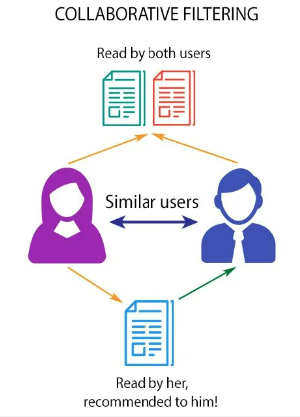

To better facilitate review of user ratings data using collaborative filtering, we can pivot our user ratings dataframe so the indices are the userId values, columns are the movie titles, and the values are the ratings given to each movie by user.

In [79]:
#Reshape the user ratings dataframe to get rows containing userIds & columns containing movie titles
user_ratings_pivot = user_ratings.pivot_table(index = 'userId', columns = 'title', values = 'rating', aggfunc = 'mean')

In [80]:
#Review user_ratings_pivot
user_ratings_pivot

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


The values of ratings imply order- i.e. 0 is a low rating and 5 is a high rating. If we were to fill NaN values present in observations where a user hasn't seen a movie with 0, this would inadvertently imply that a user disliked a movie and this may not true. Since we don't want to inadvertently skew a user's tastes, we will instead center each user's ratings around 0 and then fill missing data with 0s.

In [270]:
#Calculate the average rating for each user
avg_ratings = user_ratings_pivot.mean(axis = 1)

In [271]:
#Center each user's ratings around 0
user_ratings_pivot_centered = user_ratings_pivot.sub(avg_ratings, axis=0)

In [272]:
#Fill missing data with 0s
user_ratings_pivot_normed = user_ratings_pivot_centered.fillna(0)

In [273]:
#Review user_ratings_pivot_normed 
user_ratings_pivot_normed

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.373362,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,1.370606,0.370606,0.000000,0.000000,0.0


**Item-based Recommendations using Collaborative Filtering**

If item A and B receive similar reviews, either positive or negative, then people will feel similarly about item A and B.

In [88]:
#Create dataframe conducive to item-based recommendation analysis by taking transpose of user_ratings_pivot_normed
movie_ratings_normed = user_ratings_pivot_normed.T

In [89]:
#Review movie_ratings_normed
movie_ratings_normed

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.312886
'Hellboy': The Seeds of Creation,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Round Midnight,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Salem's Lot,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Til There Was You,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,1.490415,0.0,0.0,0.0,0.0,1.370606,0.0,0.000000
xXx,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.26087,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.370606,0.0,-1.687114
xXx: State of the Union,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-2.187114


In [96]:
#Calculate similarities between movies in the dataset using cosine similarity
#With normed ratings values - cosine similarities may range from -1 to 1 where 1 is most similar & -1 is least similar

#Review cosine similarities between 2 similar films 'Star Wars Episode IV - A New Hope' & 'Star Wars Episode V - The Empire Strikes Back'
#Get user rating values from each row
#Reshape into 1D numpy array
#Calculate cosine similarity based on user ratings - should be close to 1
cosine_similarity(movie_ratings_normed.loc['Star Wars: Episode IV - A New Hope', :].values.reshape(1,-1), movie_ratings_normed.loc['Star Wars: Episode V - The Empire Strikes Back', :].values.reshape(1,-1))

array([[0.69419867]])

In [95]:
#Repeat exercise using 2 movies that are very dissimilar - 'Jurassic Park' & 'Pulp Fiction'
#Cosine similarity should be closer to -1
cosine_similarity(movie_ratings_normed.loc['Jurassic Park', :].values.reshape(1,-1), movie_ratings_normed.loc['Pulp Fiction', :].values.reshape(1,-1))

array([[0.03385563]])

In [97]:
#Find the similarities between movies using all user ratings at once
similarities = cosine_similarity(movie_ratings_normed)

In [99]:
#Wrap the cosine similarities into a dataframe
#Now you can see how similar movies are to each other based on user ratings
cosine_similarity_df = pd.DataFrame(similarities, index = movie_ratings_normed.index, columns = movie_ratings_normed.index)

In [104]:
#For example, to find the similarity values for a specific movie - i.e. 'xXx'
xXx_cosine_sims = cosine_similarity_df.loc['xXx']

In [105]:
#Sort these values from highest to lowest
sorted_xXx_cosine_sims = xXx_cosine_sims.sort_values(ascending = False)

In [106]:
#Review how similar other movies in data are to 'xXx' based on other user ratings using cosine similarities
sorted_xXx_cosine_sims

title
xXx                                                            1.000000
Adanggaman                                                     0.555136
Endurance: Shackleton's Legendary Antarctic Expedition, The    0.555136
Kiss Me Kate                                                   0.555136
Rugrats in Paris: The Movie                                    0.540473
                                                                 ...   
Perfect Crime, The                                            -0.385864
Muppet Christmas Carol, The                                   -0.418211
Great Muppet Caper, The                                       -0.454677
Chorus Line, A                                                -0.478823
Soft Fruit                                                    -0.555136
Name: xXx, Length: 9396, dtype: float64

**Using K-Nearest Neighbors for Item Rating Prediction**

Predict how a user might rate an item even if the item is not similar to an item the user has previously seen

Find similar users using a K-Nearest neighbors model and see how they liked the item.

KNN finds the k users that are closest measured by a specific metric, to the user in question. Then it averages the rating those users gave the item we are trying to get a rating for. Allows us to predict how a user may feel about an item even if the user hasn't seen the item before.

**User-user similarity**

In [110]:
#Construct cosine similarities df for user-user similarities
user_user_similarities = cosine_similarity(user_ratings_pivot_normed)

#Put user-user similarities into a df
user_user_similarities_df = pd.DataFrame(user_user_similarities, index = user_ratings_pivot_normed.index, columns = user_ratings_pivot_normed.index)

In [111]:
#Review user_user_similarities_df
user_user_similarities_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.001279,0.000590,0.049433,0.022008,-0.047110,-0.013769,0.047964,0.019495,-0.008565,...,0.018306,-0.018415,-0.017746,-0.038083,-0.029530,0.013176,0.053681,0.076626,-0.026641,0.002664
2,0.001279,1.000000,0.000000,-0.017164,0.021796,-0.021051,-0.011277,-0.048085,0.000000,0.003012,...,-0.054566,-0.031581,-0.001703,0.000000,0.000000,0.001398,-0.020504,-0.005949,-0.060091,0.025070
3,0.000590,0.000000,1.000000,-0.011260,-0.031539,0.004800,0.000000,-0.032471,0.000000,0.000000,...,-0.004904,-0.016117,0.017863,0.000000,-0.001437,-0.037502,-0.007789,-0.013147,0.000000,0.016060
4,0.049433,-0.017164,-0.011260,1.000000,-0.029620,0.011498,0.058999,0.002065,-0.005874,0.051590,...,-0.037687,0.060523,0.029643,-0.013782,0.040044,0.017082,0.014628,-0.037299,-0.017884,-0.000992
5,0.022008,0.021796,-0.031539,-0.029620,1.000000,0.009111,0.010269,-0.012284,0.000000,-0.033165,...,0.015964,0.012427,0.027204,0.012461,-0.036334,0.029245,0.031896,-0.006048,0.093829,-0.000286


In [112]:
#User-based dataframe with center values
user_ratings_pivot_normed.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.373362,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [113]:
#User-based dataframe with uncentered scores & missing values
user_ratings_pivot.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [168]:
#Review user ratings for 'Waiting to Exhale'
waiting_to_exhale = user_ratings_pivot.loc[:, 'Waiting to Exhale']

In [169]:
#Review users that have rated movie 'Waiting to Exhale'
waiting_to_exhale

userId
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
       ..
606   NaN
607   NaN
608   NaN
609   NaN
610   NaN
Name: Waiting to Exhale, Length: 610, dtype: float64

For this specific K-Nearest Neighbors example, let's determine expected rating if userId = 5 were to watch the movie 'Waiting to Exhale' as the user ratings data shows that this specific user hasn't seen this film.

In [180]:
#Drop the movie ratings you are trying to predict 
#i.e. 'Waiting to Exhale' column in the centered, filled with zeroes df
other_movies_ratings = user_ratings_pivot_normed.drop('Waiting to Exhale', axis = 1)

#Get the data for the user you are trying to predict the outcome for  
# i.e. all normalized, centered ratings associated with userId == 5, excluding their 'Waiting to Exhale' rating
target_user_x = other_movies_ratings.loc[[5]]

#Get the target movie user ratings data from the raw user ratings table 
#i.e. 'Waiting to Exhale' ratings for all users, these values are raw values (uncentered, unnormalized ratings)
other_users_y = user_ratings_pivot['Waiting to Exhale']

In [181]:
#Drop user ratings data for users that haven't seen 'Waiting to Exhale'
#This results in centered, normalized data only from users that have seen 'Waiting to Exhale'
other_users_x = other_movies_ratings[other_users_y.notnull()]

In [182]:
#Drop the rows that are empty
#This results in raw ratings data only from users that have seen 'Waiting to Exhale'
other_users_y.dropna(inplace = True)

In [183]:
#Instantiate KNeighbors Regressor
user_knn = KNeighborsRegressor(metric = 'cosine', n_neighbors = 3)

In [184]:
#Fit user_knn using other_users_x & other_users_y -i.e. training x & y data
#other_users_x = centered, normalized ratings data only from users that have seen 'Waiting to Exhale'
#other_users_y = uncentered, unnormalized ratings values for all users that have seen 'Waiting to Exhale'
user_knn.fit(other_users_x, other_users_y)

KNeighborsRegressor(metric='cosine', n_neighbors=3)

In [185]:
#Predict on user values that we are looking to predict
#target_user_x = all normalized, centered ratings associated with userId == 5
#Predicts the average rating of nearest neighbors
user_knn.predict(target_user_x)

array([1.5])

In [194]:
#Try the same process but using a different n_neighbors = 5
user_knn_5 = KNeighborsRegressor(metric = 'cosine', n_neighbors = 5)

In [195]:
#Fit the training data using n_neighbors = 5
user_knn_5.fit(other_users_x, other_users_y)

KNeighborsRegressor(metric='cosine')

In [196]:
#Fit the user_knn_5 with n_neighbors = 5 to the training data to see how results vary
user_knn_5.predict(target_user_x)

array([2.1])

KNeighbors Classifier - finds the most common neighbors' rating

In [198]:
#Instantiate KNeighborsClassifier using n_neighbors = 3
user_knn_classifier_3 = KNeighborsClassifier(n_neighbors = 3, metric = 'cosine')

In [200]:
#Fit the training data using n_neighbors = 3
#Need to convert these values to 
user_knn_classifier_3.fit(other_users_x.astype('int'), other_users_y.astype('int'))

KNeighborsClassifier(metric='cosine', n_neighbors=3)

**Item-based recommendations**

**Pros:** <br>
-More consistent over time (i.e. user preferences may change) <br> 
-Easier to explain (based on content of an item, easier for a person to rationalize vs the preferences of another user they may have never met before) <br> 
-Can be pre-calculated by using inventory data, which is generally more static (new users may constantly appear and it is more challenging to keep user-based data current) <br>

<br>

**Cons:** <br>
-Can be obvious suggestions (i.e. not helpful to suggest another movie in the same series etc.)
 <br>

**User-based recommendations**

**Pros:** <br>
-Can create more unexpected suggestions
<br>
<br>
**Cons:** <br>
-Item-based recommendations typically are superior when compared using standard metrics

In [ ]:
user_rating_predictor = predicts based on what similar users gave the movie
movie_rating_predict = predicts based on what raings this user gave to similar movies
***Chapter 3

Quantifying the Amount of Data in Matrix

- Sparsity = (Empty Values/ Total Cells)

- Density = 1 - Sparsity

In [213]:
#Calculate the sparsity of the user_ratings_pivot df

#Calculate the sum of null values in df
number_of_empty = user_ratings_pivot.isnull().values.sum()

#Calculate total number of cells in df
total_number = user_ratings_pivot.size

#Calculate the sparsity
sparsity = number_of_empty/total_number

#Review sparsity value
print('Sparsity: ', str(round(sparsity, 5)))

#Review density value
print('Density: ', str(round(1-(sparsity), 5)))

Sparsity:  0.98249
Density:  0.01751


This user_ratings_pivot matrix would be considered sparse as nearly 98% of of the possible data is missing and ~1.7% of the possible data is present. This is important to keep in mind for our KNeighbors algorithm, we are using other user's recommendations for the same movie to predict if the user in question who hasn't seen the movie would like it. If not many other users' ratings data is available, our predictions will suffer.

KeyError: 'title'

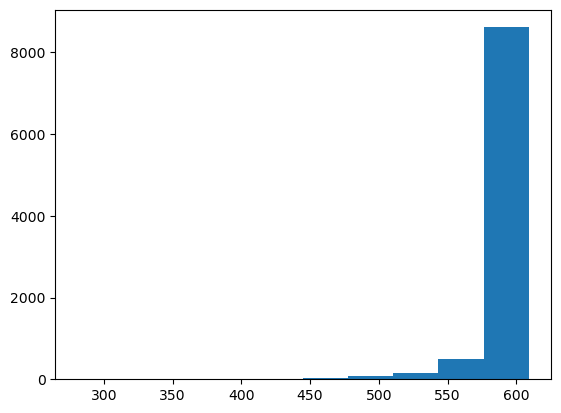

In [225]:
#Reviewing the sparsity per column
sparsity_cols = user_ratings_pivot.isnull().sum().sort_values(ascending = False)

#Make a histogram to review number of missing values per column
plt.hist(sparsity_cols)
plt.xlabel(sparsity_cols['title'])
plt.show()

In [218]:
#Review the density per column
user_ratings_pivot.notnull().sum().sort_values(ascending = True)

title
'71                               1
Late Night Shopping               1
Late Marriage                     1
Last of the Dogmen                1
Last Year's Snow Was Falling      1
                               ... 
Matrix, The                     278
Silence of the Lambs, The       279
Pulp Fiction                    307
Shawshank Redemption, The       317
Forrest Gump                    329
Length: 9396, dtype: int64

In [226]:
#Use matrix factorization to deal with sparsity issue with singular value decompisition (SVD)
#Need to use centered, normalized data
user_ratings_pivot_normed.head()

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.373362,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [275]:
#Applying SVD using default number of features, k =6
#Need to convert normalized ratings df to numpy array or sparse array for this method, dataframe can't be input
U, sigma, Vt = svds(user_ratings_pivot_normed.to_numpy())

In [279]:
#Review each element created via SVD method
print(U)
print(U.shape, '\n')

print(sigma)
print(sigma.shape, '\n')

print(Vt)
print(Vt.shape, '\n')

[[-0.01685261  0.00633408 -0.01022402 -0.00085871 -0.01009285  0.02354276]
 [ 0.00215249 -0.00143633  0.00151476  0.00131715  0.00311894 -0.00074937]
 [ 0.00877659 -0.01048372  0.01129445 -0.00381821  0.00628377 -0.00394737]
 ...
 [ 0.15851315  0.07819151  0.16663538  0.10288606 -0.0644409   0.13118765]
 [-0.00479721  0.00290488  0.00019396  0.00483054 -0.00159388  0.00386095]
 [-0.01027128 -0.09687202  0.13177288  0.0603947   0.13016123  0.16594611]]
(610, 6) 

[36.33649698 37.75531141 39.13249446 41.44389433 43.07743266 75.78852526]
(6,) 

[[-8.84437925e-05 -5.04210139e-05  1.36785258e-05 ...  2.15429750e-03
  -1.37751038e-03 -9.63421825e-04]
 [-8.02797806e-04 -1.30680713e-06  6.26287469e-06 ...  3.26240120e-03
   7.66599082e-03 -7.11583662e-04]
 [ 1.05359662e-03 -2.36740262e-04  7.40616217e-05 ... -1.25174310e-02
   6.37589086e-03 -1.13942982e-03]
 [ 4.55957267e-04  2.62326030e-04 -5.62487961e-05 ... -9.24047387e-03
   2.82117624e-03  7.27505267e-06]
 [ 9.45404568e-04 -1.00694685e-0

In [280]:
#Convert sigma into a diagonal matrix
sigma_diag = np.diag(sigma)

#Review sigma diagonal matrix & its shape
print(sigma_diag)
print(sigma_diag.shape, '\n')

[[36.33649698  0.          0.          0.          0.          0.        ]
 [ 0.         37.75531141  0.          0.          0.          0.        ]
 [ 0.          0.         39.13249446  0.          0.          0.        ]
 [ 0.          0.          0.         41.44389433  0.          0.        ]
 [ 0.          0.          0.          0.         43.07743266  0.        ]
 [ 0.          0.          0.          0.          0.         75.78852526]]
(6, 6) 



In [282]:
#Recalculating the original matrix

#1st take dot product of U & sigma matrices
U_sigma = np.dot(U, sigma_diag)

#Then take dot product of U_sigma & Vt
U_sigma_Vt = np.dot(U_sigma, Vt)

#Review results
print(U_sigma_Vt)
print(U_sigma_Vt.shape, '\n')

[[ 2.35766935e-04  4.85547019e-04 -2.48777973e-04 ... -6.85319757e-03
  -2.16733493e-02  3.69086205e-04]
 [ 2.12072299e-04 -2.74860267e-05  1.73046571e-05 ... -2.12998847e-03
   2.83437286e-03 -1.10538345e-04]
 [ 7.34026099e-04 -2.43594590e-04  9.32867621e-05 ... -4.76593922e-03
   6.04044031e-03 -4.82781506e-04]
 ...
 [ 1.01223151e-02  1.37564137e-03 -8.78326717e-04 ... -1.60257896e-01
  -5.88686292e-02 -1.78035951e-02]
 [ 1.62205311e-04  1.19713188e-04 -4.73509320e-05 ... -3.90070325e-03
  -1.81768354e-03 -8.31682364e-07]
 [ 2.34606031e-02  1.19145227e-03 -6.90327094e-04 ... -2.72193211e-01
   1.31023863e-02 -8.10082857e-03]]
(610, 9396) 



In [283]:
#Add back the row means that are in the avg_ratings attribute
uncentered_ratings = U_sigma_Vt + avg_ratings.values.reshape(-1,1)

In [284]:
#Create a dataframe for these results
calc_pred_ratings_df = pd.DataFrame(uncentered_ratings, index = user_ratings_pivot_normed.index, columns = user_ratings_pivot_normed.columns)

In [285]:
#Review the recalculated & original dataframes

#Recalculated ratings_df after SVD - much less missing (i.e. less sparsity) data makes them more useful for recommendations
calc_pred_ratings_df

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,4.373598,4.373848,4.373114,4.373421,4.372878,4.374777,4.363923,4.371263,4.373365,4.372765,...,4.364457,4.372060,4.374496,4.373776,4.373346,4.396129,4.346531,4.366509,4.351689,4.373732
2,3.948488,3.948248,3.948293,3.948271,3.948342,3.948112,3.950425,3.948751,3.948555,3.948325,...,3.948600,3.949858,3.947468,3.947156,3.948242,3.945635,3.945394,3.946146,3.951110,3.948165
3,2.436631,2.435654,2.435991,2.435842,2.436145,2.435776,2.443097,2.438654,2.439216,2.436051,...,2.445312,2.441162,2.433041,2.431968,2.435776,2.427879,2.437275,2.431131,2.441938,2.435415
4,3.553369,3.556072,3.555350,3.555830,3.555234,3.558764,3.489747,3.545179,3.543923,3.555193,...,3.504354,3.539475,3.563305,3.566894,3.555798,3.589137,3.542330,3.581245,3.532633,3.557253
5,3.636057,3.636621,3.636267,3.636447,3.636188,3.638026,3.632840,3.635119,3.635523,3.636209,...,3.629872,3.632551,3.638479,3.638881,3.636445,3.645108,3.635618,3.638394,3.628167,3.637019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.655585,3.659586,3.654880,3.657422,3.654282,3.677068,3.553716,3.637692,3.674804,3.653719,...,3.621371,3.630774,3.671773,3.671485,3.657062,3.790878,3.655463,3.646859,3.529290,3.661264
607,3.785789,3.786326,3.785988,3.786097,3.785769,3.785512,3.789316,3.784758,3.786325,3.785856,...,3.789832,3.783688,3.787724,3.787985,3.786190,3.793030,3.787357,3.784290,3.778592,3.786159
608,3.139516,3.130770,3.128516,3.129966,3.129516,3.106027,2.832355,3.090738,3.241231,3.126893,...,3.324301,3.222406,3.085806,3.068085,3.129248,3.218904,3.172181,2.969136,3.070525,3.111590


In [286]:
#Original user ratings data, with no normalization - missing lots of data
user_ratings_pivot

title,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Salem's Lot,'Til There Was You,'Tis the Season for Love,"'burbs, The",'night Mother,*batteries not included,...All the Marbles,...,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,anohana: The Flower We Saw That Day - The Movie,eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.5,3.5,NaN,NaN,NaN


In [289]:
#Use the dataframe created from SVD to find movies that userId == 5 would likely enjoy

#First Sort the ratings of User 5 from high to low
user_5_ratings = calc_pred_ratings_df.loc[5 , :].sort_values(ascending = False)

In [290]:
#Review user_5 sorted ratings
user_5_ratings

title
Pulp Fiction                                 3.731901
Schindler's List                             3.717633
Godfather, The                               3.713347
Shawshank Redemption, The                    3.710419
Fargo                                        3.707761
                                               ...   
Matrix Revolutions, The                      3.582101
Mission: Impossible II                       3.577022
Armageddon                                   3.571788
Independence Day                             3.550596
Star Wars: Episode I - The Phantom Menace    3.540030
Name: 5, Length: 9396, dtype: float64

In [ ]:
#Calculate root mean squared error
print(mean_squared_error(actual_values[mask], predicted_values[mask], squared = False))

**Comparison of Recommendation Methods**

Complete a comparison of different recommendations explored so far using the root mean squared error as the metric.
<br>
<br>
1.) Use predictions for movie ratings based on average ratings per user.
<br>
2.) Use the calculated predictions for movie ratings obtained. using matrix factorization/SVD.
<br>
<br>
Compare both of these to the actual ratings values using root mean squared error as metric